<a href="https://colab.research.google.com/github/Snrbsk/btk-manisa-yapayZeka/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0192 - val_loss: 0.0379
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0042 - val_loss: 0.0238
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - val_loss: 0.0221
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_loss: 0.0158
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 0.0133
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - val_loss: 0.0105
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - val_loss: 0.0085
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - val_loss: 0.0080
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 0.0093
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0030 - val_loss: 0.0069
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0026 - val_loss: 0.0073
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s

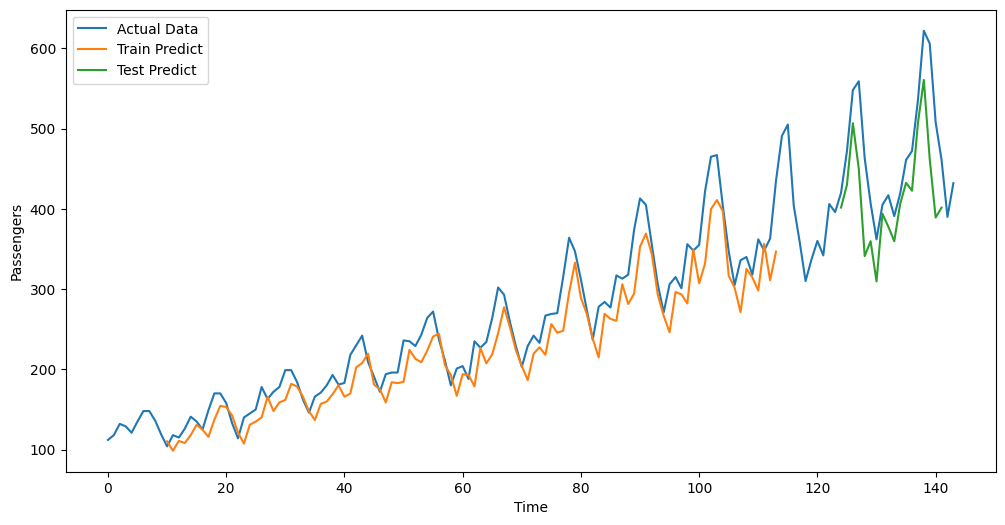

Train MAE: 25.49
Test MAE: 56.11
Train MSE: 1144.28
Test MSE: 4414.75
Train RMSE: 33.83
Test RMSE: 66.44


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
import pickle

# Veriyi yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, usecols=[1])
data = data.values.astype('float32')

# Veriyi 0 ile 1 arasında ölçekleyelim
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# Veriyi eğitim ve test olarak ayırma (80% eğitim, 20% test)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# GRU modeli için veri şekillendirme
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Veriyi GRU girişine uygun hale getirme
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# GRU modeli oluşturma
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test))

# Tahminler
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Tahminleri ölçeklendirmeyi geri alma
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Gerçek değerleri ölçeklendirmeyi geri alma
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Eğitim ve test verisi için tahminleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual Data')
plt.plot(range(time_step, len(train_predict) + time_step), train_predict, label='Train Predict')
plt.plot(range(len(train_predict) + (time_step * 2), len(train_predict) + (time_step * 2) + len(test_predict)), test_predict, label='Test Predict')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Modeli kaydetme
model.save('air_passenger_gru_model.h5')

from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE, MSE ve RMSE hesaplama
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
